In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from tensorflow.python.client import device_lib
print( device_lib.list_local_devices())
import sys

import socket
# import gpu_lock

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import metrics

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12071800815513435665
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11592600781
locality {
  bus_id: 2
}
incarnation: 12076402908127550946
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:81:00.0"
]


Using TensorFlow backend.


In [ ]:
# Example: VAE trained on MNIST 

/home/yadongl1/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Output "custom_variational_layer_17" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_17" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 190.4899 - val_loss: 172.4254
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 170.0577 - val_loss: 167.8223
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 166.8672 - val_loss: 165.5672
Epoch 4/50
60000/60000 [==============================] - 3s - loss: 164.8457 - val_loss: 164.0405
Epoch 5/50
60000/60000 [==============================] - 3s - loss: 163.3706 - val_loss: 162.9232
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 162.2197 - val_loss: 161.7500
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 161.2152 - val_loss: 161.0025
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 160.3029 - val_loss: 160.1398
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 159.4824 - val_loss: 159.3947
Epoch 10/50
60000/60000 [==============================] - 

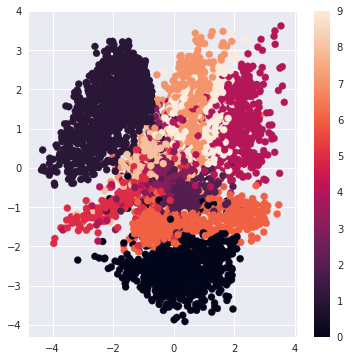

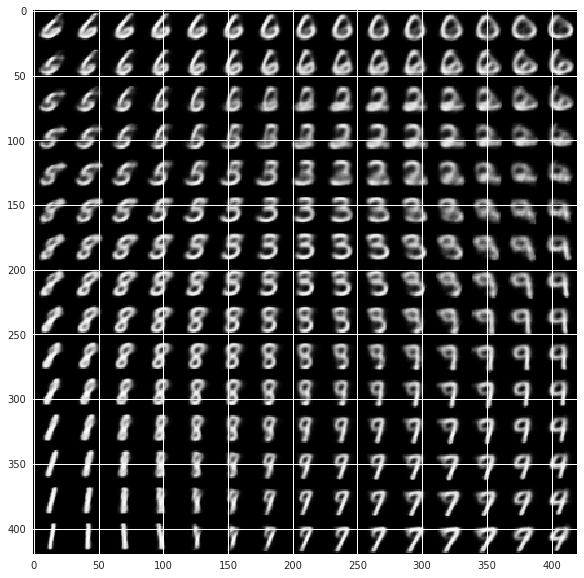

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()



# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Example: VAE on Mixture of Gaussian

## 1d Gaussian

In [48]:
# original_dim = 2
# # x_train = np.asarray([0.5*np.random.normal(0, 1, 100000) + 0.5*np.random.normal(1, 1, 100000), 
# #                       np.random.normal(0, 1, 1000)] )
# x1 = np.random.normal( 3.75, 0.75, 100000) + np.random.normal(6.00, 0.50, 100000)
# x2 = np.random.normal(0, 1, 100000)
# x_train = np.swapaxes([x1,x2], 0,1)
# np.swapaxes([[1,2,3],[4,5,6]],0,1)

In [72]:
keep = np.random.choice(2,100000 ) ## Uniformly choose 0 or 1
c1 = np.random.normal( 0, .1, 100000)
c2 =  np.random.normal( , .15, 100000)


In [17]:
dt = np.random.normal( 0.5, .1, 100000)
# for i in range(100000):
#     if keep[i] == 1:
#         dt[i] = c2[i]
        

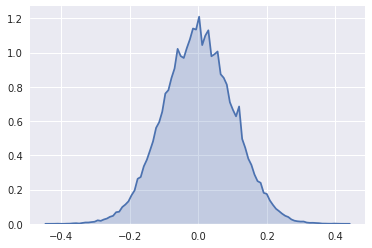

In [4]:
sns.kdeplot(dt[:80000], shade=True)

## 2d_gaussian

In [58]:
keep = np.random.choice(2,100000 ) ## Uniformly choose 0 or 1
c1 = np.random.normal( 0, .1, 100000)
c2 =  np.random.normal( 5, .1, 100000)
x1 = np.random.normal( 0, .1, 100000)
for i in range(100000):
    if keep[i] == 1:
        x1[i] = c2[i]

x2 = np.random.normal( 0, .1, 100000)
dt_2d = np.swapaxes([x1,x2], 0,1)
# dt_2d = pd.DataFrame(dt_2d, columns=['x1', 'x2'])

print(dt_2d.shape)

# with sns.axes_style('white'):
#     sns.jointplot("x1", "x2", dt_2d, kind='kde')

(100000, 2)


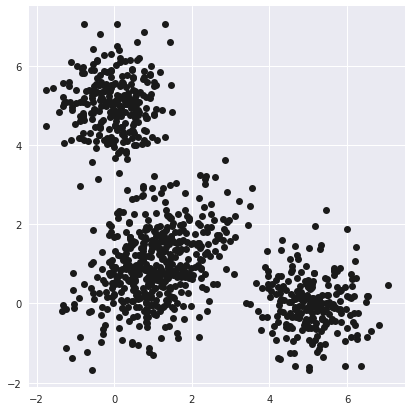

In [38]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(1000, init_means, init_covariances, init_weights)
data = np.asarray(data)


plt.figure()

plt.figure(figsize=(6, 6))
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.savefig("2d_data.png", dpi = 400)

# Model Train

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras import optimizers

batch_size = 100
original_dim =  n_pixels #1 #784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# define generator
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
#         xent_loss = (1/original_dim) * K.log(K.sum((x_decoded_mean)))
        xent_loss =  original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

from keras import metrics

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

vae.compile(optimizer=RMSprop , loss=None, metrics=[metrics.mae, metrics.categorical_accuracy])


# train the VAE on MNIST digits
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


## data from Gaussian and mixture of 1d Guassian
# x_train = dt[:10000,]
# x_test = dt[80000:, ]

## data from Gaussian and mixture of 2d Guassian
# x_train = dt_2d[:80000,]
# x_test = dt_2d[80000:, ]
# x_train = data[:500,]
# x_test = data[900:, ]

## data from Guassian 1d
# x_train = np.random.normal( 10, 1, 80000)
# x_test = np.random.normal( 10, 1, 20000)


history = vae.fit(x = X_train,y = X_val,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size
#         validation_data=(x_test, None),
#                    verbose=2
       )

/home/yadongl1/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: Output "custom_variational_layer_14" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_14" during training.


Epoch 1/100
1800/1800 [==============================] - 0s - loss: 372.7653     
Epoch 2/100
1800/1800 [==============================] - 0s - loss: 359.4188     
Epoch 3/100
1800/1800 [==============================] - 0s - loss: 357.2344     
Epoch 4/100
1800/1800 [==============================] - 0s - loss: 356.3804     
Epoch 5/100
1800/1800 [==============================] - 0s - loss: 355.0554     
Epoch 6/100
1800/1800 [==============================] - 0s - loss: 354.6540     
Epoch 7/100
1800/1800 [==============================] - 0s - loss: 353.7683     
Epoch 8/100
1800/1800 [==============================] - 0s - loss: 353.3648     
Epoch 9/100
1800/1800 [==============================] - 0s - loss: 352.6219     
Epoch 10/100
1800/1800 [==============================] - 0s - loss: 352.1486     
Epoch 11/100
1800/1800 [==============================] - 0s - loss: 351.7899     
Epoch 12/100
1800/1800 [==============================] - 0s - loss: 351.2347     
Epoch 13/100


1800/1800 [==============================] - 0s - loss: 348.6969     
Epoch 100/100
1800/1800 [==============================] - 0s - loss: 348.6636     


# Predict from Latent Space

In [73]:
import pandas as pd

n = 50
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))
# grid_x = np.random.normal( 0, 1, n)
# grid_y = np.random.normal( 0, 1, n)
x_decoded = np.zeros(n)

# 1d
if original_dim == True:
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded[i] = generator.predict(z_sample)
        
        
# 2d 
# if original_dim == 2:
#     x_decoded = np.zeros((n,2))
#     for i, yi in enumerate(grid_x):
#         for j, xi in enumerate(grid_y):
#             z_sample = np.array([[xi, yi]])
#             x_decoded[i,] = generator.predict(z_sample)
#     x_decoded = pd.DataFrame(x_decoded, columns=['x1', 'x2'])

        

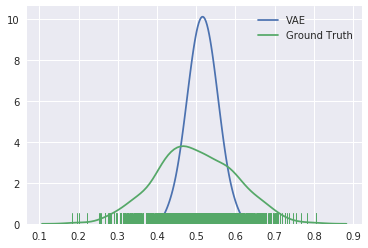

In [32]:
# plt.hist(x_decoded)
# sns.kdeplot(x_decoded, shade=True)
sns.distplot(x_decoded, hist=False, rug=True, label= "VAE")
sns.distplot(dt[:1000], hist=False, rug=True, label= "Ground Truth")

# plt.ylim(0, 3)
plt.savefig("1d_mixture3.png", dpi=400)

# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = generator.predict(z_sample)

## 2d Gaussian mixture decoding

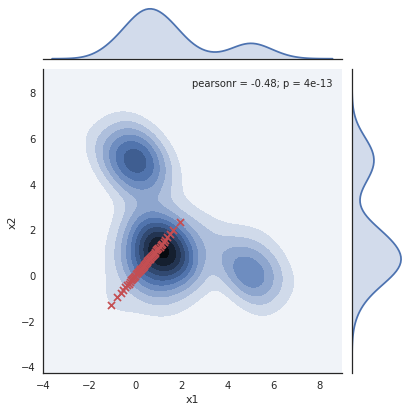

In [68]:
data = pd.DataFrame(data, columns=['x1', 'x2'])
with sns.axes_style('white'):
    graph = sns.jointplot("x1", "x2", data.loc[:200,], kind='kde')
    graph.x = x_decoded.x1
    graph.y = x_decoded.x2
#     graph.plot_joint(sns.jointplot, kind='kde' )
    graph.plot_joint(plt.scatter, marker='x', c='r', s=50)
# plt.savefig("2d_mixture.png", dpi=400)


#     sns.jointplot("x1", "x2", x_decoded.loc[:200,], kind='kde')

In [ ]:
x_decoded

# Generator Predict

In [24]:
z_sample = np.array([[4,0]])
generator.predict(z_sample).shape
generator.predict(z_sample)
# x_train[:10]

array([[ 2.84827805]], dtype=float32)

In [51]:
x_decoded



array([ 1.60877776,  1.58865857,  1.57106495,  1.55559134,  1.54155064,
        1.52860856,  1.51634789,  1.50462174,  1.49337578,  1.48256278,
        1.47214293,  1.46205449,  1.4522717 ,  1.44279194,  1.43359113,
        1.42459679,  1.41569662,  1.40677023,  1.39897728,  1.3913672 ,
        1.38392878,  1.37665081,  1.36952472,  1.36266422,  1.35673904,
        1.35116529,  1.34631014,  1.34153867,  1.33684659,  1.33222961,
        1.32768464,  1.32320762,  1.31879568,  1.31492233,  1.3111248 ,
        1.30737734,  1.30367708,  1.30002284,  1.29641223,  1.29284334,
        1.28931451,  1.28582406,  1.28278875,  1.27993703,  1.2771132 ,
        1.27431679,  1.27154613,  1.26880074,  1.26617837,  1.2639277 ,
        1.26207805,  1.26053786,  1.25980139,  1.25907016,  1.25834489,
        1.25762439,  1.25728273,  1.25718188,  1.25730133,  1.25722361,
        1.25714636,  1.25706959,  1.25699306,  1.256917  ,  1.25684142,
        1.25676632,  1.25669146,  1.25661731,  1.25654292,  1.25

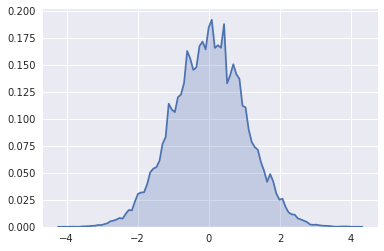

In [107]:
sns.kdeplot(x_test, shade=True)

In [120]:
vae.summary()
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_61 (Dense)                 (None, 256)           512         input_25[0][0]                   
____________________________________________________________________________________________________
dense_62 (Dense)                 (None, 2)             514         dense_61[0][0]                   
____________________________________________________________________________________________________
dense_63 (Dense)                 (None, 2)             514         dense_61[0][0]                   
___________________________________________________________________________________________

# Example: VAE on Frey Face Dataset

In [59]:
import os
from urllib.request import urlopen
from scipy.io import loadmat


url = "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
f = urlopen(url)
with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())


In [63]:
# reshape data for later convenience
data_filename = os.path.basename(url)
img_rows, img_cols = 28, 20
ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
ff = ff["ff"].T.reshape((-1, img_rows, img_cols))
np.random.seed(42)
n_pixels = img_rows * img_cols
X_train = ff[:1800]
X_val = ff[1800:1900]
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), n_pixels))
X_val = X_val.reshape((len(X_val), n_pixels))

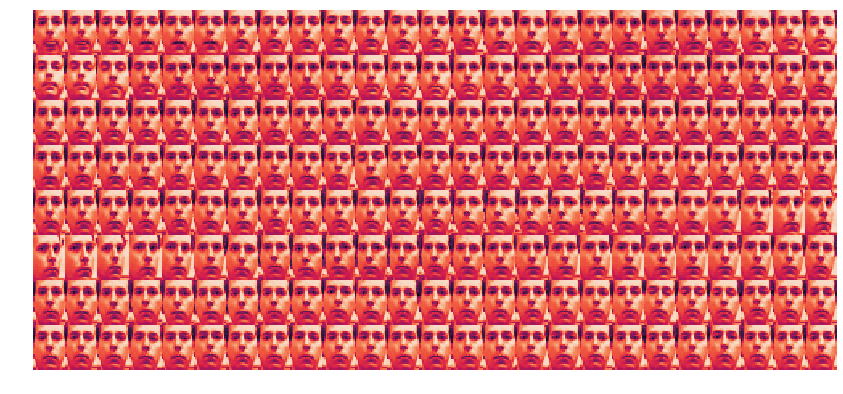

In [64]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(ff, n=200, n_cols=25)

In [65]:
n_pixels

560

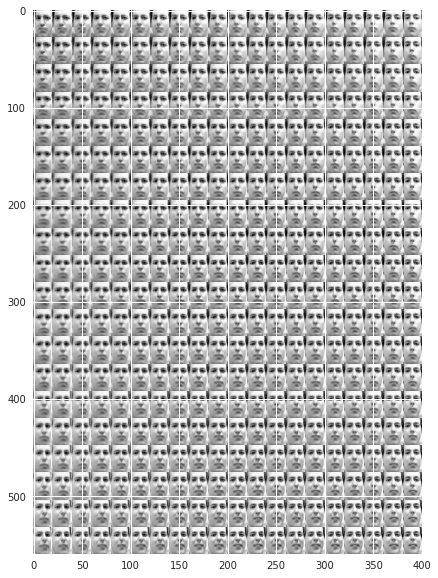

In [79]:
n = 20  # figure with 15x15 digits
img_rows, img_cols = 28, 20
figure = np.zeros((img_rows * n, img_cols * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(img_rows, img_cols)
        figure[i * img_rows: (i + 1) * img_rows,
               j * img_cols: (j + 1) * img_cols] = digit

plt.figure(figsize=(12, 10))
plt.imshow(figure, cmap='Greys_r')
plt.savefig("frey.png", dpi = 400)
plt.show()
